In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 400)
import os
import json

In [2]:
def get_best_eval_acc(ckpt):
    with open(os.path.join(ckpt, "trainer_state.json")) as f:
        state = json.load(f)
    results = [x for x in state["log_history"] if "eval_accuracy" in x]
    best_run = max(results, key=lambda x: x["eval_accuracy"])
    return best_run

def find_best_checkpoint(directory):
    ckpts = [os.path.join(directory, x) for x in os.listdir(directory) if x.startswith("checkpoint-")]
    ckpts = [x for x in ckpts if os.path.isdir(x)]
    # yeees we could also just read the latest ckpts state but who really cares...
    results = [get_best_eval_acc(x) for x in ckpts]
    best_run = max(results, key=lambda x: x["eval_accuracy"])
    return best_run["eval_accuracy"]

# Experiment 1: Contrasting Moral Stories
***
We ran several models over varying $p$.

In [5]:

def load_exp1(model_path):
    data = []
    for folder in os.listdir(model_path):
        p = float(folder)
        r = find_best_checkpoint(os.path.join(model_path, folder))
        data.append((p,r))
    data = pd.DataFrame(data, columns=["p","accuracy"])
    data = data.sort_values("p").reset_index(drop=True)
    return data


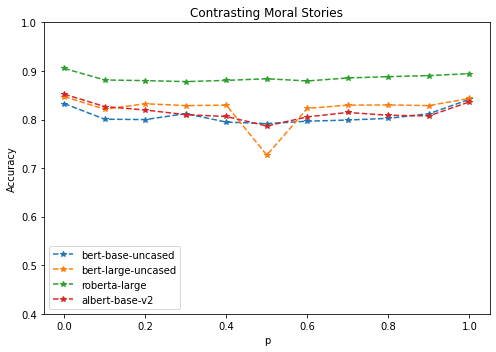

In [18]:
path_pretrained = "/data/kiehne/results/shuffled_values/random/"

models_pretrained = ["bert-base-uncased","bert-large-uncased", "roberta-large", "albert-base-v2"]

plt.figure(figsize=(7,5))
for model in models_pretrained:
    data = load_exp1(os.path.join(path_pretrained, model))
    plt.plot(data["p"], data["accuracy"],"--*", label=model)
plt.ylim(0.4,1)
plt.ylabel("Accuracy")
plt.legend()
plt.xlabel("p")
plt.title("Contrasting Moral Stories")
plt.tight_layout()
plt.savefig("../data/img/exp1.svg")
plt.show()

# Experiment 2:  Random BERT
***
We train a randomly initialized BERT on the CMS dataset

TODO
* Also do the other models?

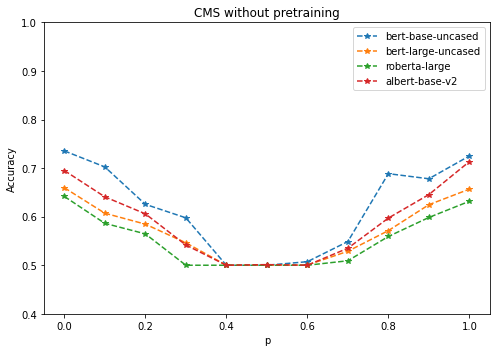

In [17]:
path_random = "/data/kiehne/results/shuffled_values/random_no_pretrain/"

models_random = ["bert-base-uncased","bert-large-uncased", "roberta-large", "albert-base-v2"]

plt.figure(figsize=(7,5))
for model in models_random:
    data = load_exp1(os.path.join(path_random, model))
    plt.plot(data["p"], data["accuracy"],"--*", label=model)
plt.ylim(0.4,1)
plt.ylabel("Accuracy")
plt.legend()
plt.xlabel("p")
plt.title("CMS without pretraining")
plt.tight_layout()
plt.savefig("../data/img/exp2.svg")
plt.show()

# Experiment 3: Sentiment analysis baseline
***
We test correlation of action sentiment and norm sentiment to moral/immoral labels. A simple rule of positive action sentiment suggesting moral actions yields 61.8%. Searching for better decision thresholds with several classifiers gives:
* RandomForest: 54.7%
* AdaBoost: 61.5%
* SVM: 61.9%

Also taking into account the sentiment of the corresponding norm does not help:
* RandomForest: 0.549%
* AdaBoost: 61.5%
* SVM: 61.9%

**Evidence of sentiment predicting morality!**

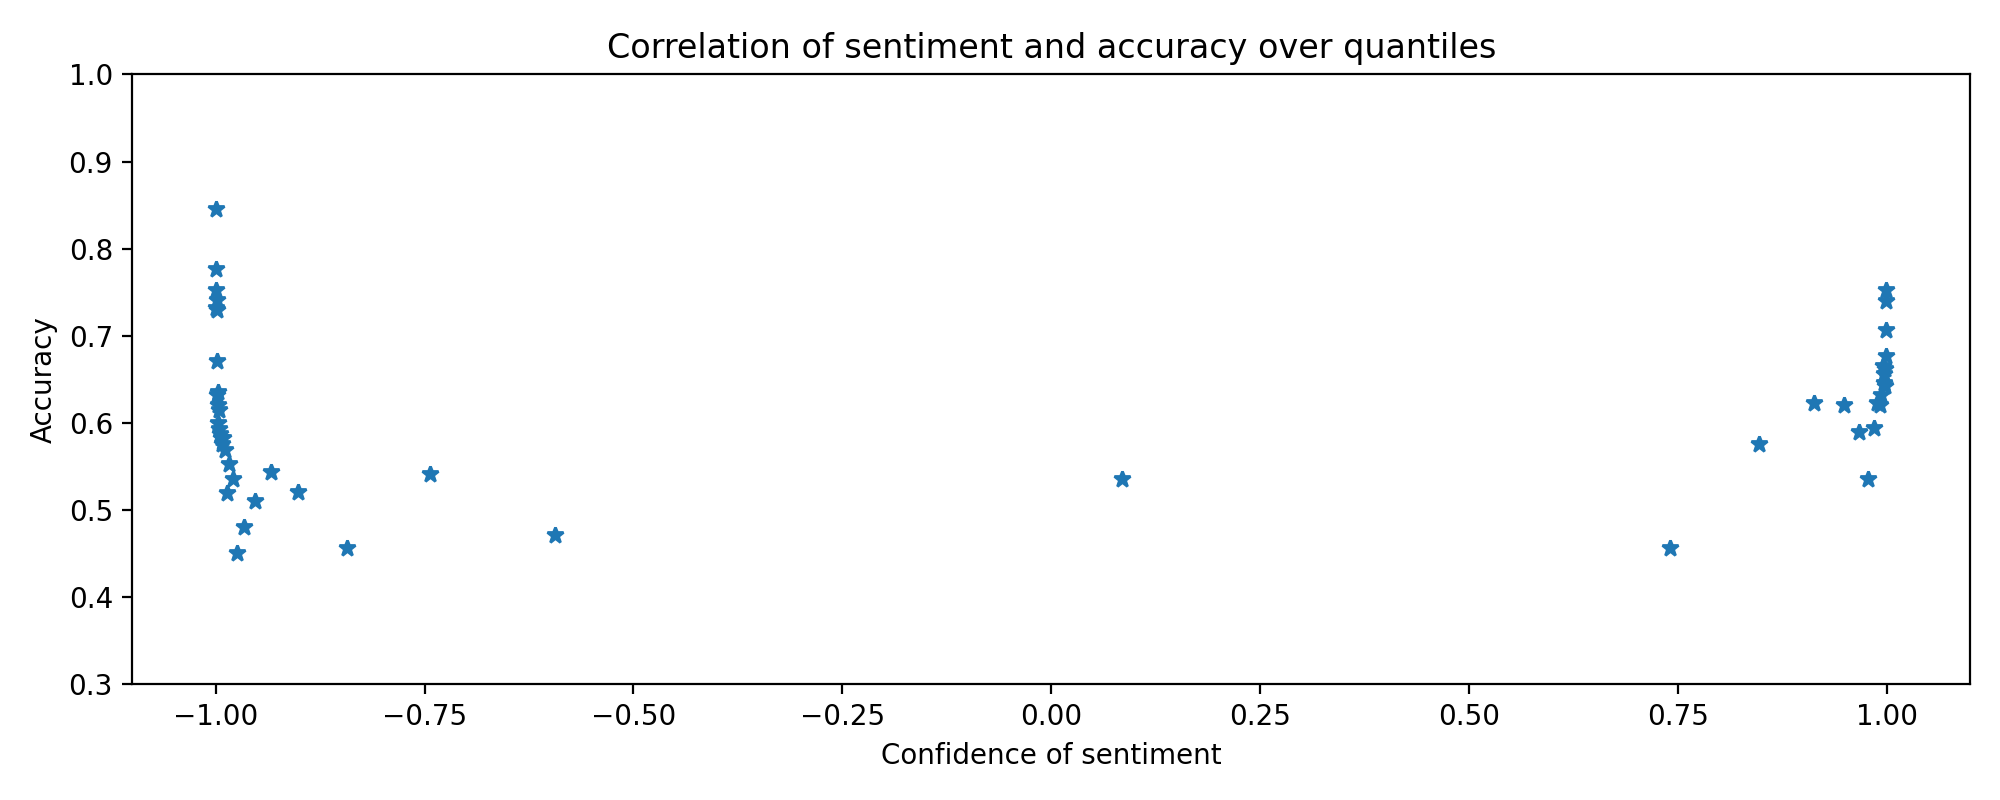

In [3]:
from IPython.display import Image
Image(filename="../data/img/exp3.svg") 

# Experiment 4: SANLI pipeline
***
We showed that sentiment is a predictor of morality, but it only works well on the highly negative or positive samples. On average, an accuracy of 62% is observed, which is substantially lower than what can be achieved given full access to the data. So what is missing?

We propose a decomposition of the task to sentiment analysis complemented by a reasoning component, namely natural language inference.

In [13]:
# copied from moral_stories_sanli notebook
results = [0.7954318106035345,
 0.7954318106035345,
 0.7954318106035345,
 0.7954318106035345,
 0.7954318106035345,
 0.7954318106035345,
 0.7954318106035345,
 0.7954318106035345,
 0.7954318106035345,
 0.7954318106035345,
 0.7954318106035345]

82.19% Pretrained: bert-large-uncased
81.58% Pretrained: albert-base-v2
80.76% Pretrained: bert-base-uncased
79.54% SANLI


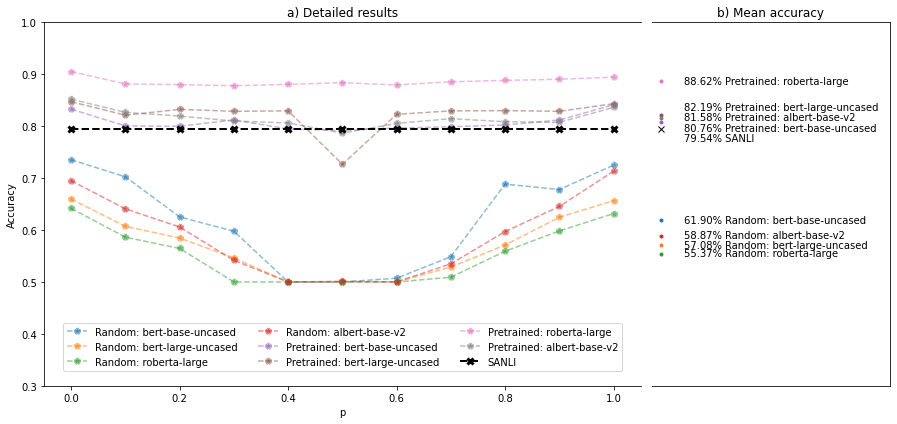

In [16]:
fig, (left, right) = plt.subplots(1,2, squeeze=True, sharey=False, figsize=(13,6),
                                 gridspec_kw={'width_ratios': [2.5, 1]})
means = []
mean_labels = []
for model in models_random:
    data = load_exp1(os.path.join(path_random, model))
    label = "Random: " + model
    left.plot(data["p"], data["accuracy"],"--*", label=label, mew=3, alpha=0.5)
    mean = data["accuracy"].mean()
    right.plot([mean],".")
    mean_label = f"{100*mean:.2f}% " + label
    mean_labels.append(mean_label)
    right.text(0.1,mean-0.005,mean_label)
    means.append(mean)
for model in models_pretrained:
    data = load_exp1(os.path.join(path_pretrained, model))
    label = "Pretrained: " + model
    left.plot(data["p"], data["accuracy"],"--*", label=label, mew=3, alpha=0.5)
    mean = data["accuracy"].mean()
    right.plot([mean],".")
    mean_label = f"{100*mean:.2f}% " + label
    mean_labels.append(mean_label)
    means.append(mean)

left.plot(np.linspace(0,1,11),results,"--x",label="SANLI", lw=2, mew=3, color="black")
mean = np.mean(results)
mean_label = f"{100*mean:.2f}% " + "SANLI"
mean_labels.append(mean_label)
means.append(mean)

# mean texts for pretrained need to be manually aligned...
off = 0.02
for i, k in enumerate([8,4,7,5][::-1]):
    mean_label = mean_labels[k]
    right.text(0.1,means[6]-0.005 - 0.03 - (i+1)*off ,mean_label)
    print(mean_label)
# add roberta...
right.text(0.1,means[6]-0.005,mean_labels[6])

left.set_ylim(0.3,1)
left.set_ylabel("Accuracy")
fig.legend(ncol=3, loc="lower center", bbox_to_anchor=(0.37,0.12))
left.set_xlabel("p")
left.spines['right'].set_visible(False)

left.set_title("a) Detailed results")


right.plot([mean],"x", color="black")
right.set_ylim(0.3,1)
right.set_xlim(-0.04,1)
right.set_title("b) Mean accuracy")
right.xaxis.set_visible(False)
right.yaxis.set_visible(False)

#right.spines['right'].set_visible(False)
#right.spines['bottom'].set_visible(False)
right.spines['left'].set_visible(False)

right.set_yticks(means)
#right.set_yticklabels([f"{100*x:.2f}%" for x in means])
#fig.suptitle("Comparison of language model performances on the CMS dataset")
plt.tight_layout()
plt.savefig("../data/img/exp4.svg",dpi=200)
plt.show()